# 09-04 - pyTorch, autograd, and Stochastic Gradient Descent

*June 26 2024*  

For the simple example discussed in the previous notebook, the parameters learned by the perceptron model (using gradient descent minimization of the loss function) are identical to the parameters that we obtained by fitting the logistic regression model (using gradient ascent maximization of the likelihood function). This is one of the simplest possible examples of a neural network, where the "network" actually consists of a single neuron that maps one or more inputs to a single output. 

We now implement this simple perceptron classifier in the popular neural network library `pytorch`. We also introduce the `autograd` feature, which is used to automatically calculate gradients of loss functions.

In [2]:
import torch
import torch.nn.functional as F
from torch.nn import Parameter

import numpy as np
import scipy.stats
import seaborn as sns
import pandas as pd
from scipy.special import expit
import matplotlib.pyplot as plt

plt.style.use('default')
sns.set_style("whitegrid")

In [3]:
def response(x, boundary=0.2, prob_1=1):
    if x > boundary:
        if np.random.random_sample() < prob_1:
            return 1
        else:
            return 0
    else:
        if np.random.random_sample() < 1-prob_1:
            return 1
        else:
            return 0

<Axes: xlabel='x', ylabel='y_class'>

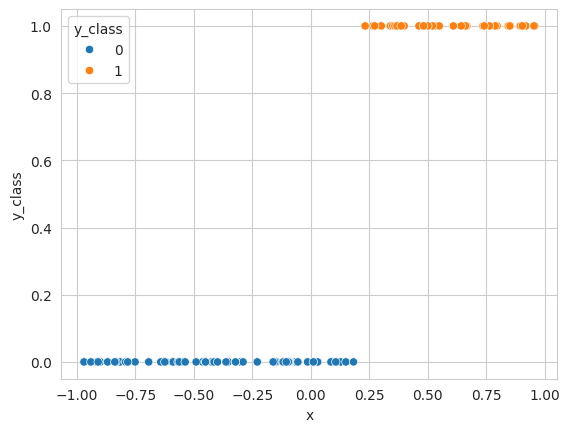

In [4]:
x = 2*scipy.stats.uniform.rvs(size=100)-1
y = np.array([ response(x[i]) for i in range(len(x)) ])

data = pd.DataFrame({'x': x, 'y_class': y})

sns.scatterplot(x='x', y="y_class", data=data, hue='y_class')

The machine learning library `pytorch` heavily builds on the `torch.tensor` data structure, i.e. all inputs and outputs are assumed to be tensors, i.e. multi-dimensional arrays or higher-dimensional generalizations of vectors and matrices.

For our example, we convert our data to a one-dimensional tensor, i.e. a vector.

In [5]:
train_x = torch.tensor(data['x'].values, dtype=torch.float32)
train_y = torch.tensor(data['y_class'].values, dtype=torch.float32)

print(train_x)
print(train_y)

tensor([ 0.9576, -0.4578, -0.3010,  0.7961, -0.6924,  0.3397,  0.2720,  0.6667,
         0.1128, -0.5932,  0.0964, -0.1515, -0.4237,  0.4621,  0.2651,  0.3503,
        -0.9683, -0.9694,  0.7880, -0.0656, -0.6200, -0.0894, -0.0903, -0.6926,
         0.2321,  0.3013,  0.5020, -0.8655,  0.0860, -0.0922, -0.1059,  0.7358,
         0.6612,  0.5313, -0.1463, -0.8996,  0.1280, -0.4630, -0.0138, -0.0959,
        -0.4901, -0.8290,  0.6427,  0.3990,  0.8951, -0.9153,  0.1499,  0.0295,
         0.3592,  0.5488, -0.4134, -0.3984,  0.5017, -0.8149, -0.5884, -0.8685,
        -0.5673,  0.7638,  0.3683, -0.1540, -0.1181,  0.9188, -0.5461,  0.9040,
         0.8438, -0.7918,  0.5193, -0.1049,  0.6093, -0.6928, -0.2274, -0.4500,
        -0.5622,  0.5006, -0.7509,  0.0108, -0.8327,  0.8509,  0.3861, -0.3533,
        -0.1612,  0.2732, -0.8376,  0.1068, -0.0552, -0.6414, -0.7824, -0.9400,
         0.4820, -0.9088, -0.2896, -0.4498, -0.3220,  0.1823,  0.9538,  0.7410,
        -0.3625, -0.6240, -0.2289, -0.53

We now implement a simple perceptron model. All models in `pytorch` are derived from the base class `torch.nn.Module`. Such a module can consist of multiple "layers" of neural networks and we can control how those layers are interconnected and what activation functions are used as data pass between the layers. By implementing the `forward` function, we control what happens as the data (i.e. our features) are passed through the (possibly multiple) layers of our model.

For our example with linearly separable classes, a single layer that consists of a single neuron with one input and one output is sufficient. In the forward function, we apply a linear transformation $f(\vec{x}) = \beta_0 + \beta_1 x_1 + \ldots$ of our input feature. We further "forward" a value that is transformed by a sigmoid "activation" function, i.e. we perform a logistic transformation of the linear combination of features which defines the output of our "network", i.e. the class probability.

Conveniently, we do not need to implement the linear transformation of the feature(s) (based on the slope and the bias parameter) ourselves. We can simply use the `torch.nn.Linear` class, which implements a single layer perceptron model and automatically includes the necessary weight parameters (i.e. the bias and slope parameters for all perceptrons and input dimensions). With this, implementing a perceptron in `pytorch` is as simple as:

In [6]:
class Perceptron(torch.nn.Module):
    
    def __init__(self):
        super(Perceptron, self).__init__()
        self.linear = torch.nn.Linear(in_features=1, out_features=1, bias=True)
        
    def forward(self, x):
        # we use a logistic transformation to output class probabilities
        # Note that torch.sigmoid is an alias for this function 
        return torch.special.expit(self.linear(x))

We can now initialize our model, choose a loss function that is used to optimize the model parameters, and pick one of the optimization algorithms implemented in `pytorch`. To understand how these optimization algorithms work, we need to explain some basics of the `autograd` module in `pytorch`. In our previous notebook, we have implemented a Gradient Descent optimization ourselves. For this, we used the gradients (calculated based on partial derivatives) that we calculated in the lecture based on the L2 loss function. We can only use those gradients for the special case of a model using a single perceptron performing a binary classification based on the logistic activation function and the L2 loss function.

However, in `pytorch` we can use arbitrarily complex, multi-layer models with various activation functions, loss functions, etc. How can we compute the gradients that we need to iteratively update the model parameters during the learning step? For this, we can use the `autograd` feature of `pytorch`. A detailed explanation of the fundamental of `autograd` is available [here](https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html). Simply speaking, thanks to the `autograd` feature all tensors trace the history of all computations, which allows to efficiently and automatically compute the local gradients that are needed by optimization algorithms. In each step of the optimization algorithm, these gradients then allow to nudge model parameters in the right direction. A simple example that illustrates the automatic gradient computation can be found [here](https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html).

We can try this as follows: We create a tensor, specifying that we want `torch` to keep track of all operations that are performed on the tensor.

In [7]:
x = torch.tensor([42.0], requires_grad=True)
print(x.detach().numpy())
print(x.grad)
print(x.grad_fn)

[42.]
None
None


We can now compute a new tensor `y` by adding a value to the elements of tensor `x`. We find that this lead to the assignment of the `grad_fn` property, which stores that tensor `y` was obtained by adding a value to tensor `x`.

In [8]:
y = x + 0.5
print(y.detach().numpy())s
print(y.grad)
print(y.grad_fn)

[42.5]
None


/tmp/ipykernel_1003/3018939081.py:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(y.grad)


If we assign a new tensor `z` my multiplying a value to tensor `y`, the `grad_fn` property stores that tensor `z` was obtained by multiplying a value to tensor `y`.

In [9]:
z = y * 0.1
print(z.detach().numpy())
print(z.grad_fn)

[4.25]


You see that by this calculations we have created a computation graph of tensors connected via the `grad_fn` properties. The output tensor `z` points to `y` and `y` points to `x`, which is our input tensor. We can call the `backward()` function of the output tensor to compute the gradients, i.e. the partial derivative of the input tensor. 

In [10]:
z.backward()
print('gradient of x =', x.grad)

gradient of x = tensor([0.1000])


This gradient can be understood if we consider how the output $z=f(x)$ is calculated based on the input $x$. We have implemented the following expression:

$ f(x) = 0.1*(x+0.5) = 0.1 x + 0.05$

The derivative of this function (i.e. the gradient w.r.t x) is 

$ f'(x) = 0.1$ 

and thus $f'(42) = 0.1$

For the following example, for $x = 42$ we expect a gradient value of $171$:

$ f(x) = 2 \cdot x^2 + 3 \cdot x + 5 $

$ f'(x) = 4 \cdot x + 3 $

$ f'(42) = 4 \cdot 42 + 3 = 171 $

In [11]:
x = torch.tensor([42.0], requires_grad=True)
y = 2 * x**2 + 3*x + 5

y.backward()
print(x.grad.detach().numpy())

[171.]




Using this convenient `autograd` feature, in `pytorch` neural networks can be trained based on backpropagation, i.e. starting from the output that we wish to minimize (i.e. the loss function) we run the backpropagation and obtain gradients for our model parameters, which can be used in the iterative optimization. This works as follows:

1.) Using the current parameter values, we calculate a **loss function**, i.e. a function that quantifies the difference between the target variable (i.e. our ground truth in the training data) and the current output of our model. Our goal is to minimize this loss function for our training data.

2.) We propagate the loss function backwards through our model, i.e. starting from the output we pass the loss backwards to the inputs. In the process, we calculate the gradients of all model parameters, which will be used in the optimization step. 

For a single-layer perceptron, the **backpropagation** algorithm corresponds to the [delta rule](https://en.wikipedia.org/wiki/Delta_rule), which yields the partial derivatives (i.e. gradient) for a perceptron with activation function \sigma(x), i.e.

$ \Delta \beta_{j}= \eta (\hat{y}_{j}-y_{j})\sigma'(h_{j})x_{i} $

where $\alpha$ is the learning rate $y_i$ is the model output and $\hat{y}_i$ is the target variable, i.e. the ground truth classes.

3.) We finally perform the actual optimization step, i.e. using the learning rate, we nudge the model parameters in the direction of the gradient.

For the sigmoid activation function $\sigma(x) = \frac{1}{e+e^{-x}}$ we obtain the gradients

$ \Delta \beta_{j}=  (\hat{y}_{s}-y_{s})y_s(1-y_s)x_{sj} $

We are now ready to train our first `pytorch` model. We follow the same approach as before, i.e. we create the model, set the hyperparameters and initialize an optimizer. Here we use the implementation of stochastic gradient descent included in `pytorch`. This actually follows the same approach as our implementation in the previous notebooks, however here the gradients are (automatically) computed such that we minimize a loss function (rather than maximizing the likelihood function).

The name "stochastic" gradient descent refers to the fact that - rather than calculating the gradient for the whole data set it is estimated based on a small sample (i.e. for the batch size used in each iteration).

In [12]:
# create perceptron and configure learning process
model = Perceptron()

# we use the mean absolute diff between target and prediction as loss function
loss_func = torch.nn.MSELoss()

# input and label 
x = train_x[0].reshape(1,)
label = train_y[0].reshape(1,)

# compute output of perceptron (incl. logistic activation function )
y = model(x)
print(y)

# compute loss function 
loss = loss_func(y, label)
print(loss)

loss.backward()

# output computed parameter gradients
print('bias gradient =', model.linear.bias.grad)
print('weight gradients =', model.linear.weight.grad)

tensor([0.5228], grad_fn=<SigmoidBackward0>)
tensor(0.2277, grad_fn=<MseLossBackward0>)
bias gradient = tensor([-0.2381])
weight gradients = tensor([[-0.2280]])


We now compare this to a analytical derivation of the gradient, which we can calculate as (see exercise sheet):

$\nabla L = (\frac{\partial L}{\partial \beta_0}, \frac{\partial L}{\partial \beta_1}) = \left(2 \cdot (\hat{y}_i-y_i)\cdot y_i\cdot (1-y_i), 2 \cdot (\hat{y}_i-y_i)\cdot y_i\cdot (1-y_i)\cdot x_i \right)$

In [13]:
y_val = y.detach().numpy()[0]
x_val = x.detach().numpy()[0]
label_val = label.detach().numpy()[0]

beta_0_grad = -2*(label_val - y_val)*y_val*(1-y_val)
print(beta_0_grad)

beta_1_grad = -2*(label_val - y_val)*y_val*(1-y_val)*x_val
print(beta_1_grad)

-0.23810232961569716
-0.22800671928958033


In [14]:
# the number of epochs gives the number of times we run the 
# optimization algorithm on all examples in our training set
epochs = 500

# the learning rate controls how much parameters are 
# changed (based on the gradients) for each training sample
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
# Set network to training mode
model.train()

errors = []

for epoch in range(epochs):

    error = 0 
    for i in range(len(train_x)):
        x = train_x[i].reshape(1,)
        label = train_y[i].reshape(1,)

        # set gradients to zero
        optimizer.zero_grad()

        # compute output and loss function
        output = model(x)
        loss = loss_func(output, label)

        # apply backpropagation to output tensor, which 
        # automatically computes gradients for model parameters
        loss.backward()

        # update model parameters based on computed gradients
        optimizer.step()

        error += loss

    errors.append(error.detach().numpy())

plt.plot(range(epochs), errors)

print('bias =', model.linear.bias.data)
print('weight =', model.linear.weight.data)

We see that the loss function decreases as the SGD optimizer moves the model parameters along the automatically calculated gradients. Note that those gradients are calculated when we call the `backward` function of the tensor `loss` (the output we wish to minimize). Using `autograd`, this will calculate the gradients of the model parameters. Note that we have to reset the previously calculated gradients for each iteration of the algorithm, i.e. we use gradients calculated for each data point separately.

In [16]:
params = [x.detach().numpy()[0] for x in model.parameters()]
print(params)

[array([13.955381], dtype=float32), -2.8154037]


In [17]:
def decision(output):
    if output>0.5:
        return 1
    else:
        return 0

           x  y_class  prediction
0   0.110956        0           0
1   0.638992        1           1
2  -0.230952        0           0
3   0.413732        1           1
4  -0.768777        0           0
..       ...      ...         ...
95  0.952566        1           1
96 -0.564877        0           0
97 -0.563177        0           0
98 -0.146379        0           0
99 -0.453292        0           0

[100 rows x 3 columns]


<AxesSubplot:xlabel='x', ylabel='y_class'>

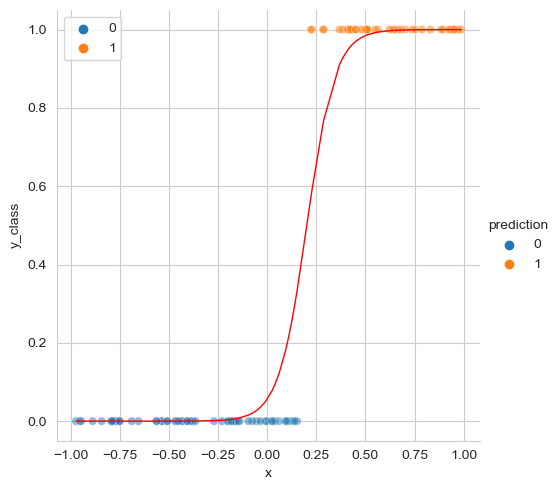

In [18]:
model.eval()

xx = data['x'].values
data['prediction'] = [ decision(model.forward(torch.tensor([x], dtype=torch.float32)).detach().numpy()[0]) for x in xx]
print(data)
sns.relplot(x='x', y="y_class", hue='prediction', data=data, alpha=0.5)
sns.lineplot(x=xx, y=expit(params[1] + xx * params[0][0]).ravel(), color='red', linewidth=1)